In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import libraries

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path

Create path variable for further read and write to disk

In [9]:
data_path = Path('/home/jupyter/tutorials/data/Competitions/CarClassification/car_data')

In [10]:
data_path.ls()

[PosixPath('/home/jupyter/tutorials/data/Competitions/CarClassification/car_data/test'),
 PosixPath('/home/jupyter/tutorials/data/Competitions/CarClassification/car_data/train'),
 PosixPath('/home/jupyter/tutorials/data/Competitions/CarClassification/car_data/models')]

Create variable of actual train and test

In [11]:
train = data_path/'train'
test = data_path/'test'
names = data_path/'../names.csv'
np.random.seed(50)

In [12]:
!head {names}

AM General Hummer SUV 2000
Acura RL Sedan 2012
Acura TL Sedan 2012
Acura TL Type-S 2008
Acura TSX Sedan 2012
Acura Integra Type R 2001
Acura ZDX Hatchback 2012
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Coupe 2012
Aston Martin Virage Convertible 2012


Check how to use from_folder

In [7]:
help(ImageDataBunch.from_folder)

Help on method from_folder in module fastai.vision.data:

from_folder(path:Union[pathlib.Path, str], train:Union[pathlib.Path, str]='train', valid:Union[pathlib.Path, str]='valid', test:Union[pathlib.Path, str, NoneType]=None, valid_pct=None, **kwargs:Any) -> 'ImageDataBunch' method of builtins.type instance
    Create from imagenet style dataset in `path` with `train`,`valid`,`test` subfolders (or provide `valid_pct`).



The train and test images are stored in respective class folder. From the folders create the training and validation dataset.

In [9]:
data = ImageDataBunch.from_folder(cars, train = 'train', valid='test', ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

In [10]:
len(data.train_ds)

8144

In [11]:
len(data.valid_ds)

8041

Show images from training set along with the labels they are assigned

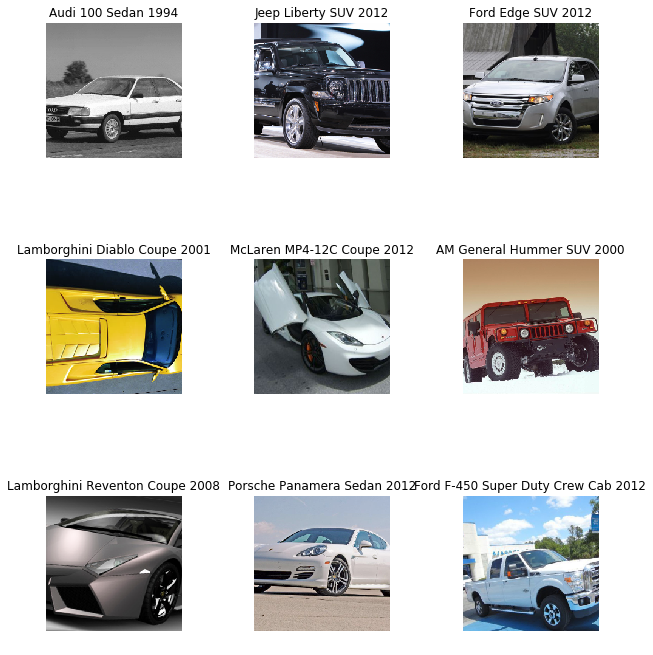

In [12]:
data.show_batch(rows=3)

Create a learner/model to train using pretrained resnet34 architecture. This model will have other properties also

In [13]:
learn_res34 = create_cnn(data, models.resnet34, metrics=error_rate)

In [28]:
help(learn_res34)

Help on ClassificationLearner in module fastai.vision.learner object:

class ClassificationLearner(fastai.basic_train.Learner)
 |  Train `model` using `data` to minimize `loss_func` with optimizer `opt_func`.
 |  
 |  Method resolution order:
 |      ClassificationLearner
 |      fastai.basic_train.Learner
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  predict(self, img:fastai.vision.image.Image)
 |      Return prect class, label and probabilities for `img`.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from fastai.basic_train.Learner:
 |  
 |  TTA = _TTA(learn:fastai.basic_train.Learner, beta:float=0.4, scale:float=1.35, is_test:bool=False, with_loss:bool=False) -> Union[torch.Tensor, Collection[_ForwardRef('Tensors')]]
 |  
 |  __del__(self)
 |  
 |  __eq__(self, other)
 |  
 |  __init__(self, data:fastai.basic_data.DataBunch, model:torch.nn.modules.module.Module, opt_func:Callable=functools.partial(<class 'torc

Learn by going through the dataset 4 times and updating the weights. See if the results improve or not.

In [15]:
learn_res34.fit_one_cycle(4)

Total time: 05:48
epoch  train_loss  valid_loss  error_rate
1      4.865151    3.851209    0.821042    (01:35)
2      3.315197    2.482240    0.600920    (01:24)
3      2.409541    1.981854    0.494217    (01:24)
4      1.926891    1.892848    0.467604    (01:24)



Plot losses made for train and test. Observe here for each batch in each epoch the train loss has been plotted but for each epoch only the test loss has been plotted. which makes sense because the test is performed after training. But there are batches for test and should we have considered each batch error rate? Probably no because the error rate is going to be almost same in each batch for a epoch and plotting it would make it look really weired.

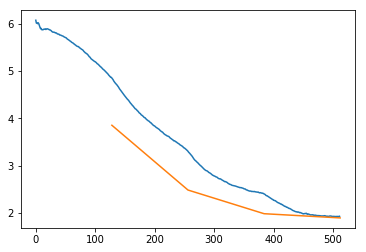

In [16]:
learn_res34.recorder.plot_losses()

Store the model for future use. it stores as pytorch model and is stored in data_location/models folder. 

In [17]:
learn_res34.save('learn_res34_4')

Previously we executed the learn without making any change to the weights of resnet34. Next we are unfreezing the weights so that we can change the weights of resnet pretrained model when the back propagation happens. Earlier we got a headstart with resnet34 weights and learning from scratch was eliminated. We just created the head/last few layers of the model on top of resnet and when back propagation happened it fine tuned those end layer weights only.
In thre fit_one_cycle by default we use lr = 3e-03 which usually works well and after unfreezing we would like to see if the same learning rate can be used for the base layers as well or we should find something new.

In [18]:
learn_res34.unfreeze()

In [19]:
learn_res34.fit_one_cycle(1)

Total time: 01:26
epoch  train_loss  valid_loss  error_rate
1      2.627446    1.810523    0.473573    (01:26)



It doesn't look bad but its good idea to see if we can use a range of lr so that the lower layer learn better and slowly where as the final layers learns fast because we need to make the initial learning more concrete so that final layers find it easy to learn.

We will load the existing model and try to find the best lr.

In [20]:
learn_res34.load('learn_res34_4')

Does it matter to load a model which has been trained more compared to less trained model and find the lr? How do we find the lr?

In [21]:
learn_res34.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


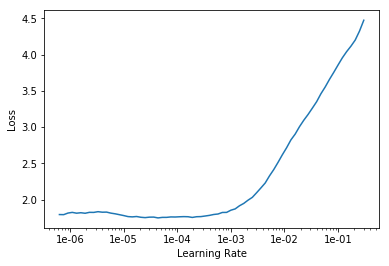

In [22]:
learn_res34.recorder.plot()

from the plot above choose the lr for which we see consistent dip in loss. Now unfreeze the model and fit it to one cycle so that the bottom layers can also be learned.

In [23]:
learn_res34.unfreeze()

In [24]:
learn_res34.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

Total time: 14:42
epoch  train_loss  valid_loss  error_rate
1      1.761992    1.805071    0.444472    (01:27)
2      1.623162    1.650112    0.407785    (01:28)
3      1.482589    1.494963    0.371844    (01:27)
4      1.288766    1.353448    0.336028    (01:30)
5      1.112572    1.245920    0.306927    (01:29)
6      0.988865    1.171926    0.291755    (01:27)
7      0.893037    1.132737    0.277453    (01:28)
8      0.797411    1.098444    0.270240    (01:28)
9      0.768636    1.086016    0.268748    (01:28)
10     0.739170    1.084317    0.267007    (01:27)



from above we can see that the model is learning and there are chances of improvement as well. But lets save the model and see how the losses are doing.

In [29]:
learn_res34.save('cars-uf-34')

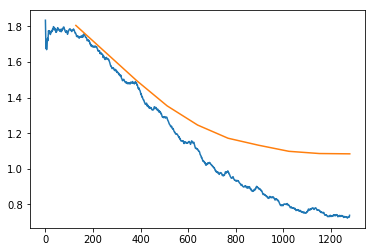

In [30]:
learn_res34.recorder.plot_losses()

From this plot we can see that the validation loss has almost flattened. So we can assume using resnet34 we can reach up to 75% accuracy.

Lets try to evaluate the model. The evaluation will run the model on validation set and it generates all the information.

In [32]:
eval_res34 = ClassificationInterpretation.from_learner(learn_res34)

eval_res34 stores the losses and probability for each image. plot_top_losses orders the data as per the descreasing loss. It also gives the predicted class vs actual class vs total loss and probability for the actual class. Can we add probability for the prediction as well? 

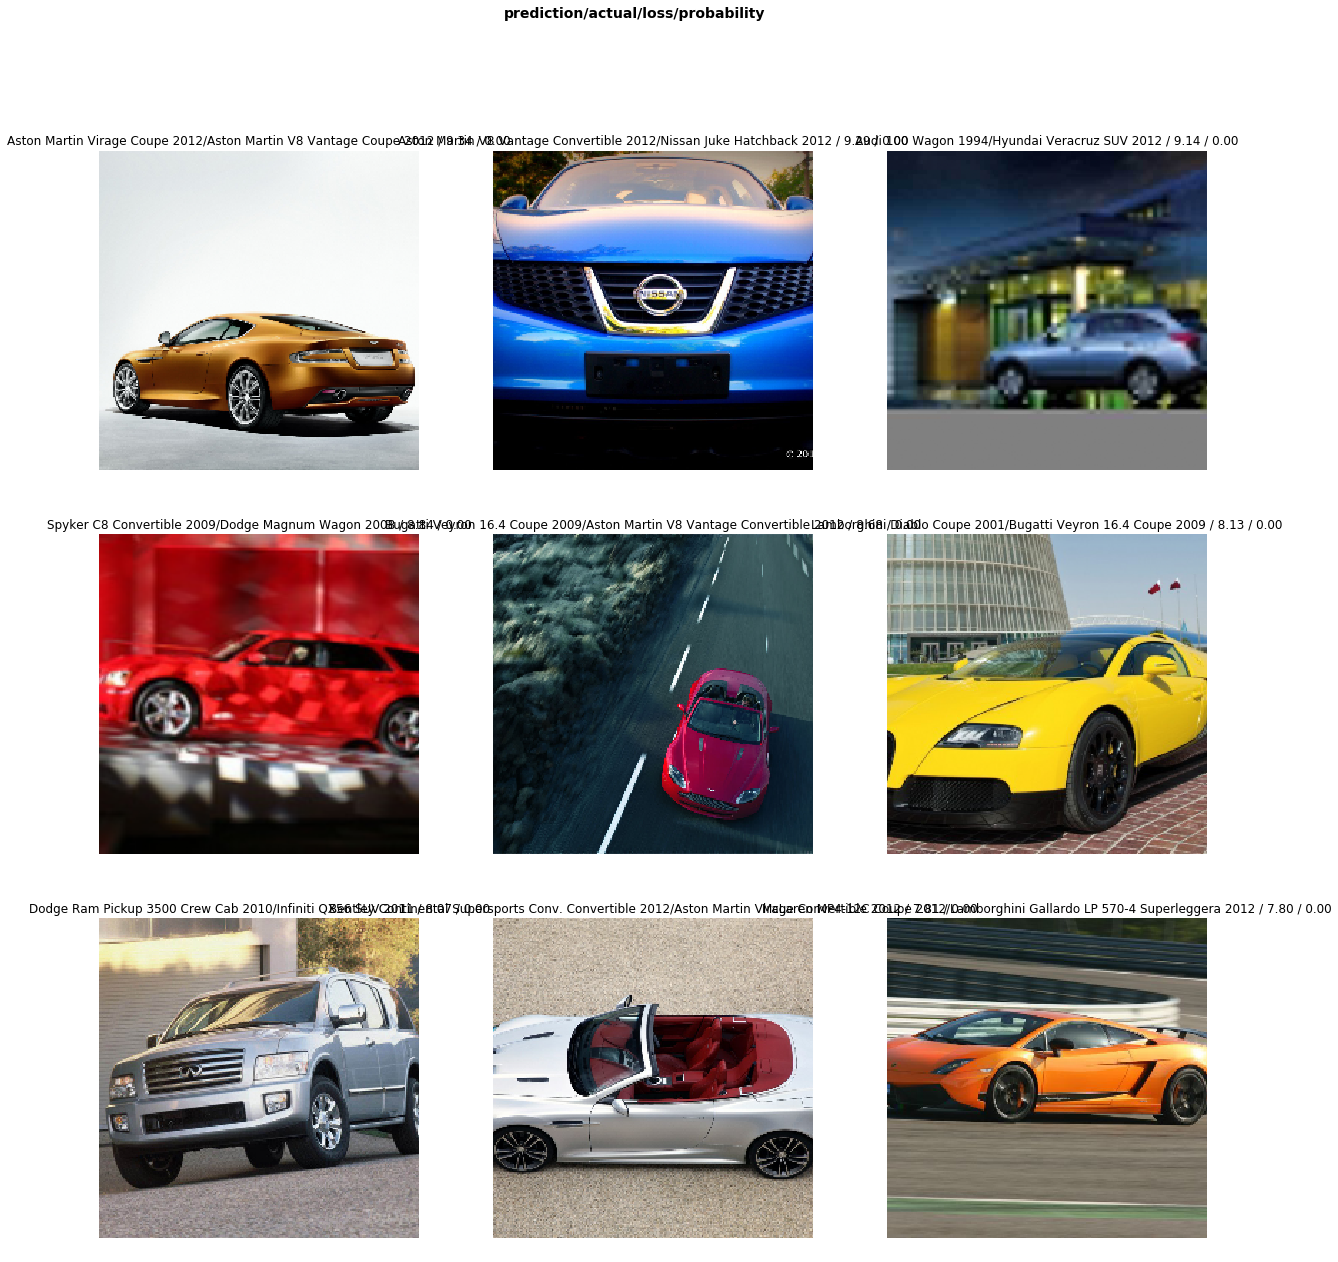

In [38]:
eval_res34.plot_top_losses(9, figsize=(20,20))

most_confused() prints out all the incorrect class classifications.

In [39]:
eval_res34.most_confused()

[('Dodge Sprinter Cargo Van 2009', 'Mercedes-Benz Sprinter Van 2012', 14),
 ('BMW 6 Series Convertible 2007', 'BMW M6 Convertible 2010', 13),
 ('Chevrolet Express Cargo Van 2007', 'Chevrolet Express Van 2007', 12),
 ('Dodge Ram Pickup 3500 Crew Cab 2010',
  'Dodge Ram Pickup 3500 Quad Cab 2009',
  12),
 ('Bentley Continental GT Coupe 2012',
  'Bentley Continental GT Coupe 2007',
  11),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 11),
 ('Audi 100 Wagon 1994', 'Audi 100 Sedan 1994', 10),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Extended Cab 2012',
  10),
 ('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 10),
 ('Ferrari 458 Italia Coupe 2012', 'Ferrari 458 Italia Convertible 2012', 10),
 ('Audi 100 Sedan 1994', 'Audi V8 Sedan 1994', 9),
 ('Audi A5 Coupe 2012', 'Audi S5 Coupe 2012', 9),
 ('Audi S5 Coupe 2012', 'Audi A5 Coupe 2012', 8),
 ('Bentley Continental GT Coupe 2007', 'Bentley Continental GT Coupe 2012', 8),
 ('Chevrolet Expres

In [ ]:
eval_res34.plot_confusion_matrix(dpi=80, figsize=(25,25))

We can go ahead with a bigger architecture resnet50 to get better accuracy following the same approach we followed for resnet34.

In [13]:
data50 = ImageDataBunch.from_folder(data_path, train = 'train', valid='test', ds_tfms=get_transforms(), size=299, bs=32).normalize(imagenet_stats)

In [14]:
learn50 = create_cnn(data50, models.resnet50, metrics = error_rate)

In [16]:
learn50.fit_one_cycle(2)

Total time: 06:35
epoch  train_loss  valid_loss  error_rate
1      1.926658    1.426841    0.379182    (03:17)
2      1.200752    1.046868    0.277702    (03:17)



Great result.. What we achieved after 10 epochs in resnet34 we achieved in 2 epochs and without much changes.

In [17]:
learn50.save('learn50-ep2')

In [18]:
learn50.unfreeze()

In [19]:
learn50.fit_one_cycle(1)

Total time: 04:09
epoch  train_loss  valid_loss  error_rate
1      2.341047    1.468025    0.372217    (04:09)



In [20]:
learn50.load('learn50-ep2')

In [21]:
learn50.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


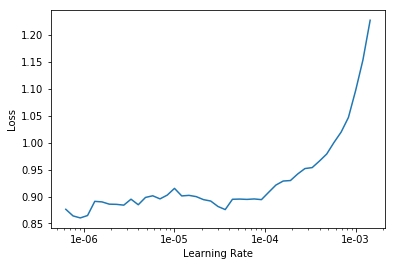

In [22]:
learn50.recorder.plot(skip_end=20)

In [49]:
learn50.unfreeze()

In [23]:
learn50.fit_one_cycle(10, max_lr=slice(1e-05, 5e-04))

Total time: 41:19
epoch  train_loss  valid_loss  error_rate
1      0.895043    0.901248    0.238154    (04:06)
2      0.772364    0.813975    0.222609    (04:08)
3      0.646712    0.740772    0.200348    (04:07)
4      0.530288    0.661782    0.178833    (04:08)
5      0.368578    0.595345    0.161796    (04:07)
6      0.265127    0.545650    0.150728    (04:07)
7      0.185445    0.488231    0.136053    (04:08)
8      0.121802    0.457182    0.128094    (04:08)
9      0.092953    0.440320    0.122373    (04:08)
10     0.070141    0.438334    0.122622    (04:07)



In [19]:
learn50.save('learn50-uf-10e')

Why we stop here? can we imprive it further? The answer I think is yes we can but lets see how we can go ahead and deploy what we have here. There is always some sort of tradeoff we need to make between accuracy and resources(time/space). Moreover we have got the overfitting indication.

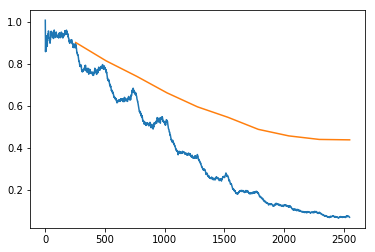

In [24]:
learn50.recorder.plot_losses()

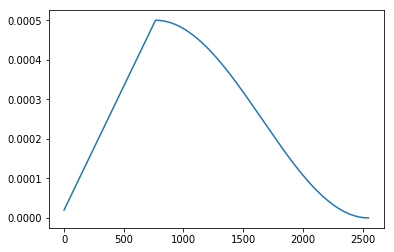

In [25]:
learn50.recorder.plot_lr()

In [ ]:
eval_learn50 = ClassificationInterpretation.from_learner(learn50)

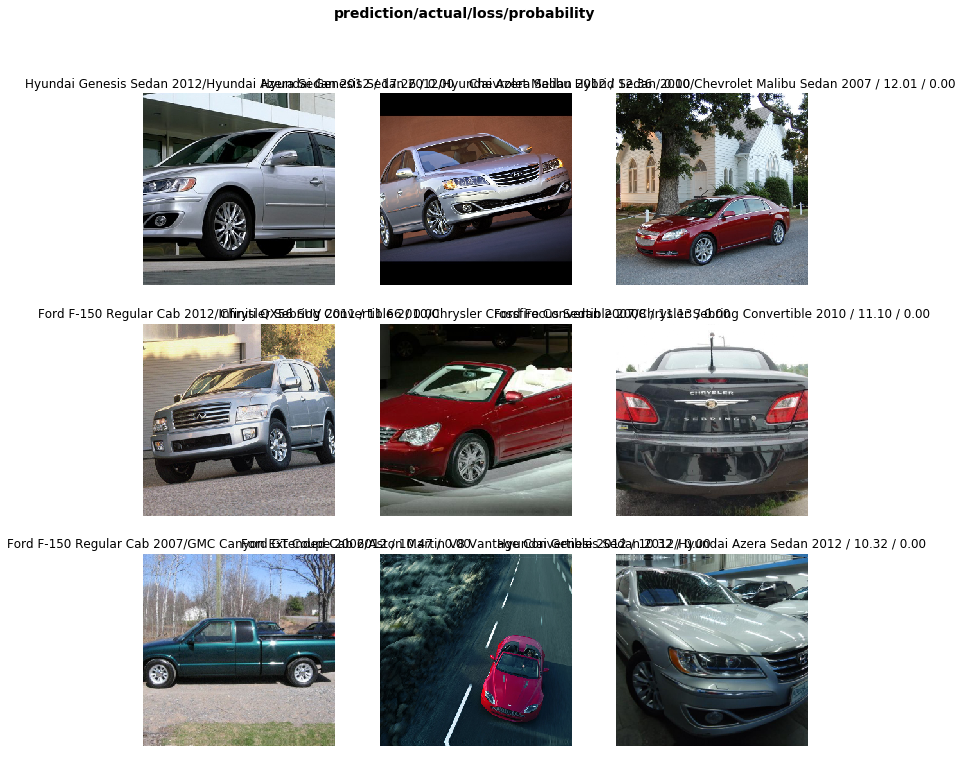

In [23]:
eval_learn50.plot_top_losses(9)

In [24]:
eval_learn50.most_confused()

[('Audi S5 Coupe 2012', 'Audi A5 Coupe 2012', 16),
 ('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 15),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 11),
 ('Chevrolet Express Cargo Van 2007', 'Chevrolet Express Van 2007', 10),
 ('Chevrolet Express Van 2007', 'Chevrolet Express Cargo Van 2007', 9),
 ('Dodge Sprinter Cargo Van 2009', 'Mercedes-Benz Sprinter Van 2012', 9),
 ('Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 8),
 ('Audi TT Hatchback 2011', 'Audi TTS Coupe 2012', 8),
 ('Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 8),
 ('BMW 6 Series Convertible 2007', 'BMW M6 Convertible 2010', 8),
 ('Bentley Continental GT Coupe 2007',
  'Bentley Continental Flying Spur Sedan 2007',
  8),
 ('Bugatti Veyron 16.4 Convertible 2009', 'Bugatti Veyron 16.4 Coupe 2009', 8),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Extended Cab 2012',
  8),
 ('Chevrolet Silverado 2500HD Regular Cab 2012',
  'Chevrolet Silverado 1500 Regular Cab 2012',
  8),
 ('Chev

In [ ]:
data50.classes